In [151]:
import yfinance as yf
import numpy as np

In [152]:
df = yf.download('BTC-USD',start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [153]:
df['returns'] = np.log(df.Close.pct_change() + 1)

In [154]:
df['directions'] = [1 if i > 0 else -1 for i in df.returns]

In [155]:
# pull lag returns
def lagit(df, lags):
    names = []
    for i in range(1,lags + 1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j > 0 else -1 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

In [156]:
dirnames = lagit(df, 5)

In [157]:
df.dropna(inplace=True)

In [158]:
from sklearn.linear_model import LogisticRegression

In [159]:
model = LogisticRegression()

In [160]:
model.fit(df[dirnames], df['directions'])

LogisticRegression()

In [161]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [162]:
df['strat_Logit'] = df['prediction_Logit'] * df['returns']

In [163]:
np.exp(df[['returns', 'strat_Logit']].sum())

returns        2.552649
strat_Logit    6.824113
dtype: float64

<AxesSubplot:xlabel='Date'>

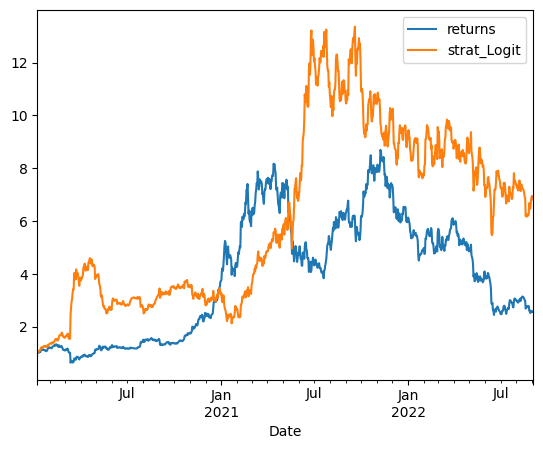

In [164]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

In [165]:
from sklearn.model_selection import train_test_split

In [166]:
train, test = train_test_split(df, shuffle=False, test_size=0.25, random_state=0)

In [167]:
train = train.copy()

In [168]:
test = test.copy()

In [169]:
model = LogisticRegression()

In [170]:
model.fit(train[dirnames], train['directions'])

LogisticRegression()

In [171]:
test['prediction_Logit'] = model.predict(test[dirnames])

In [172]:
test['strat_Logit'] = test['prediction_Logit'] * test['returns']

In [173]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        0.426881
strat_Logit    0.602689
dtype: float64

<AxesSubplot:xlabel='Date'>

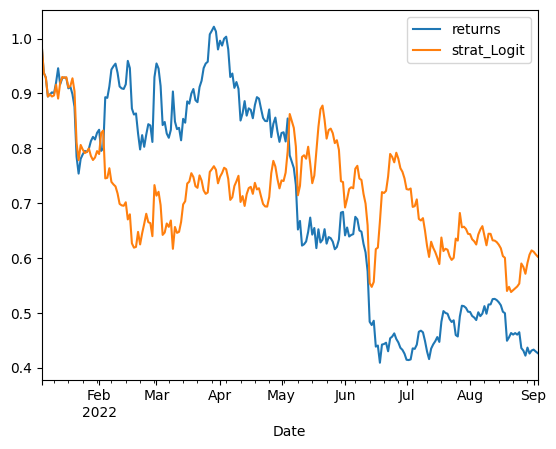

In [174]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

In [175]:
from sklearn import metrics

In [176]:
metrics.confusion_matrix(test['directions'], test['prediction_Logit'])

array([[46, 82],
       [49, 66]], dtype=int64)

In [177]:
print(metrics.classification_report(test['directions'], test['prediction_Logit']))

              precision    recall  f1-score   support

          -1       0.48      0.36      0.41       128
           1       0.45      0.57      0.50       115

    accuracy                           0.46       243
   macro avg       0.47      0.47      0.46       243
weighted avg       0.47      0.46      0.45       243

